# Z-shaped metasurface design

In [112]:
import sys
import os, importlib.util
from pathlib import Path
# import lumapi
LUMAPI_PATH = os.environ.get("LUMAPI_PATH")
spec = importlib.util.spec_from_file_location("lumapi", LUMAPI_PATH)
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

In [113]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c

# import custom modules
sys.path.append("../module")
from MetaTool import setResources, addMaterialNK, getMatrixCenter

### 2.1 Parameter

In [114]:
# Cell 2 — config for building from scratch (SI units)
from pathlib import Path
import os, sys, numpy as np

# keep the notebook stable regardless of where it's opened from
repo = Path.cwd()
for p in [repo, *repo.parents]:
    if (p/"module").exists() :
        os.chdir(p); repo = p; break
print("CWD:", os.getcwd())

hide = False
# --- geometry / user properties (match your Structure Group) ---
p    = 300e-9   # period (x/y span of unit cell)
l1   = 120e-9   # top horizontal extent
l3   = 80e-9   # lower setback (controls diagonal)
l2   =  66e-9   # vertical separation of arms (center-to-center)
t    =  50e-9   # in-plane bar width
t_z  =  60e-9   # extrusion height

# substrate / padding
substrate_thick = 500e-9


# materials (use the same library names you used in the UI)
mat_z   = "Ag (Silver) - Palik (0-2um)"
mat_sub = "Custom_Glass"  # Custom material with n=1.45, k=0
if mat_sub == "Custom_Glass":
    n = 1.45  # refractive index of cylinder material
    k = 0  # imaginary refractive index


# spectrum
lam_start = 500e-9
lam_stop  = 800e-9
wavelength_number    = 301
wavelength_vec = c / np.linspace(c / lam_stop, c / lam_start, wavelength_number)
separation = lam_stop / 2



# simulation size
sim_x_span = p
sim_y_span = p

# boundary conditions: PML / Period / Bloch / (Anti-)Symmetric
boundary_x_min = "Period"
boundary_x_max = "Period"
boundary_y_min = "Period"
boundary_y_max = "Period"
boundary_z_min = "PML"
boundary_z_max = "PML"

# mesh settings
# automate un-uniform x, y, and z
mesh_accuracy = 3

# names (keep them consistent with the screenshots)
FDTD_NAME = "FDTD"
SRC_NAME  = "src"
T_MON     = "T"


print("Config ready.")

CWD: c:\Users\z5493038\OneDrive - UNSW\Desktop\Project-2
Config ready.


### 2.2 Simulation

In [152]:
# open fdtd
fdtd = lumapi.FDTD(hide=hide)
print(">> Progress: FDTD is opened.")

>> Progress: FDTD is opened.


In [153]:
if mat_sub == "Custom_Glass":
    addMaterialNK(fdtd, "Custom_Glass", n=n, k=k)

In [154]:
# resource settings
parallel_job_number = 1
processes = 1
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [155]:
# define layout mode
if fdtd.layoutmode() != 1:  
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects
# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    simulation_time=300e-15,
    y_span=sim_y_span,
    z_min=float(-t_z-2*separation),
    z_max=float(t_z +2*separation),
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy,
    mesh_type="auto non-uniform",
    mesh_refinement="conformal variant 0",
    
    
)

# source
source = fdtd.addplane(
    name="src",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=separation+t_z,
    # propagation direction
    injection_axis="z",
    direction="backward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    polarization_angle=0,
    # phase
    phase=0,
    # bandwidth
    wavelength_start=lam_start,
    wavelength_stop=lam_stop,
)

# metaatom
fdtd.addstructuregroup(name="Z")
fdtd.setnamed("Z", "construction group", 1)   # enable "Script" tab

sg_script = f'''
# ===== user parameters (meters) =====
l1 = {l1};
l3 = {l3};
l2 = {l2};
t  = {t};
t_z = {t_z};
mat = "{mat_z}";

vtx = [ 
  t,        l2/2;
  l1,       l2/2;
  l1,       l2/2 + t;
  0,        l2/2 + t;
  0,       -l2/2;
  t - l3,  -l2/2;
  t - l3,  -l2/2 - t;
  t,       -l2/2 - t
];

# ===== build the polygon, extruded to t_z =====
addpoly;
set("name","Ag");              # child name shown in your tree
set("material", mat);
set("vertices", vtx);
set("z span", t_z);
set("x", 0);
set("y", 0);
set("z", t_z/2);          # move to sit on substrate
'''

fdtd.setnamed("Z", "script", sg_script)

mesh_buffer = 20e-9  # small padding around the metal

#  optimized mesh bounds based on geometry
x_max = min(sim_x_span/2, l1 + mesh_buffer)
x_min = max(-sim_x_span/2, -((l3 - t) + mesh_buffer))
x_center = (x_max + x_min) / 2
x_span_optimized = x_max - x_min

#  optimized y_span based on Z-shape geometry
y_span_optimized = min(sim_y_span, l2 + 2*t + 2*mesh_buffer)

silver_mesh = fdtd.addmesh(
    name="silver_mesh",
    # region covering the meta-atom with optimized bounds
    x=x_center,
    x_span=x_span_optimized,
    y=0.0,
    y_span=y_span_optimized,
    z=0.5*t_z,
    z_span=t_z + 2*mesh_buffer,

    # override automesh in this box
    override_x_mesh=1,
    override_y_mesh=1,
    override_z_mesh=1,

    # choose to set max mesh step directly
    set_maximum_mesh_step=1,
    dx=2.5e-9,
    dy=2.5e-9,
    dz=2e-9,
)

# substrate
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=float(-substrate_thick),
    material=mat_sub
)
# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=-separation,
)




In [156]:
import datetime

fsp_dir = Path("fsp"); fsp_dir.mkdir(parents=True, exist_ok=True)
FIXED_FSP_NAME = "z_atom_0.fsp" 
if FIXED_FSP_NAME:
    fsp_path = fsp_dir / FIXED_FSP_NAME
else:
    stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    fsp_path = fsp_dir / f"Z_shaped_from_notebook_{stamp}.fsp"

# Save

path_str = str(fsp_path).replace("\\", "/")
try:
    fdtd.save(path_str)
except Exception:
    fdtd.eval(f'save("{path_str}")')

print("Saved project to:", fsp_path.resolve())

Saved project to: C:\Users\z5493038\OneDrive - UNSW\Desktop\Project-2\fsp\z_atom_0.fsp


In [ ]:
import importlib
from pathlib import Path


import module.E_x_E_y_run as exy
exy = importlib.reload(exy)

OUT_DIR = Path("data") / "z_shape"


df_lin, df_cir = exy.two_run_jones(
    fdtd,
    lam_start, lam_stop, wavelength_number,
    mon_name="T", src_name="src",
    out_dir=OUT_DIR, basename="jones", save_csv=True,
    debug=True,
)

# plot 
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)


Locked grid on monitor 'T' (per-monitor).


300fs,1e-5,variant 0,mesh buffer 10 nm,dx=2.5nm,dy=2.5nm,mesh accuracy=3,time 300fs


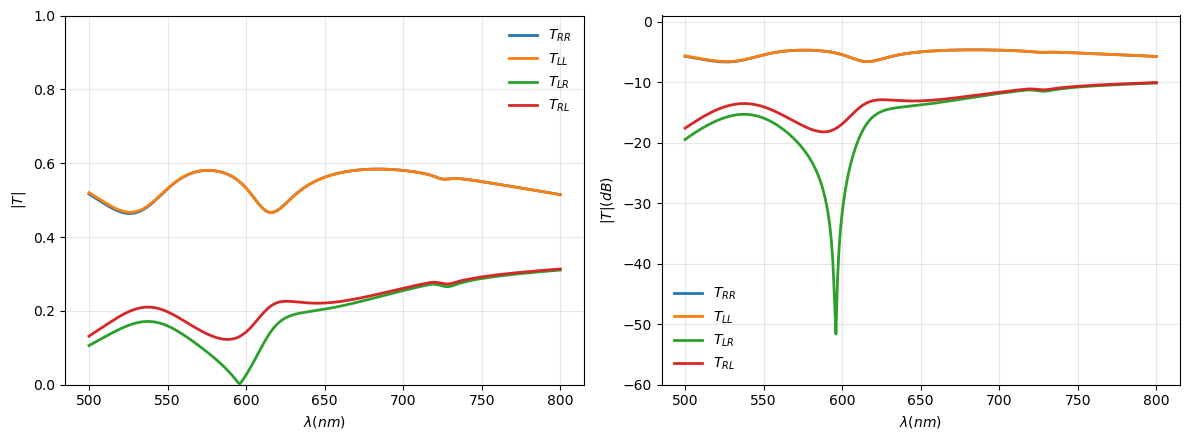

In [132]:
# plot 
print("300fs,1e-5,variant 0,mesh buffer 10 nm,dx=2.5nm,dy=2.5nm,mesh accuracy=3,time 300fs")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5,variant 0,mesh buffer 20 nm,dx=3nm,dy=3nm,mesh accuracy=3,time 1000fs


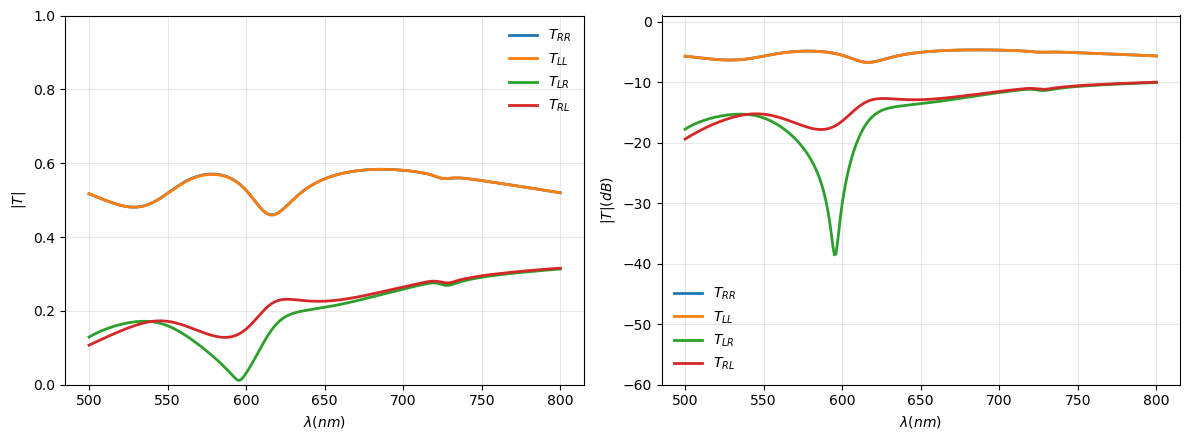

In [125]:
# plot 
print("300fs,1e-5,variant 0,mesh buffer 20 nm,dx=3nm,dy=3nm,mesh accuracy=3,time 1000fs")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5,variant 0,mesh buffer 20 nm,dx=2.5nm,dy=2.5nm,mesh accuracy=3


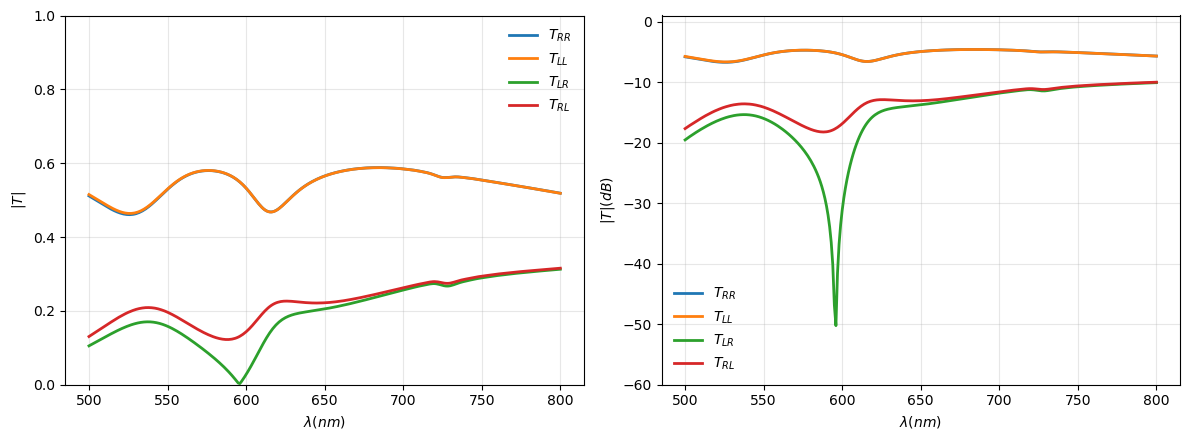

In [111]:
# plot 
print("300fs,1e-5,variant 0,mesh buffer 20 nm,dx=2.5nm,dy=2.5nm,mesh accuracy=3")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5,variant 0,mesh buffer 20 nm,dx=2.5nm,dy=2.5nm


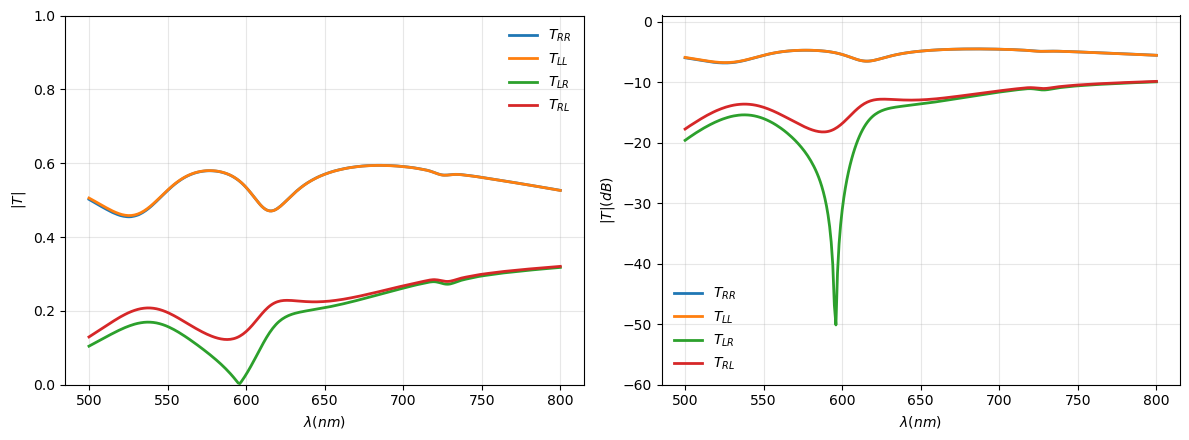

In [100]:
# plot 
print("300fs,1e-5,variant 0,mesh buffer 20 nm,dx=2.5nm,dy=2.5nm")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5,variant 0,mesh buffer 20 nm,dx=3nm,dy=3nm


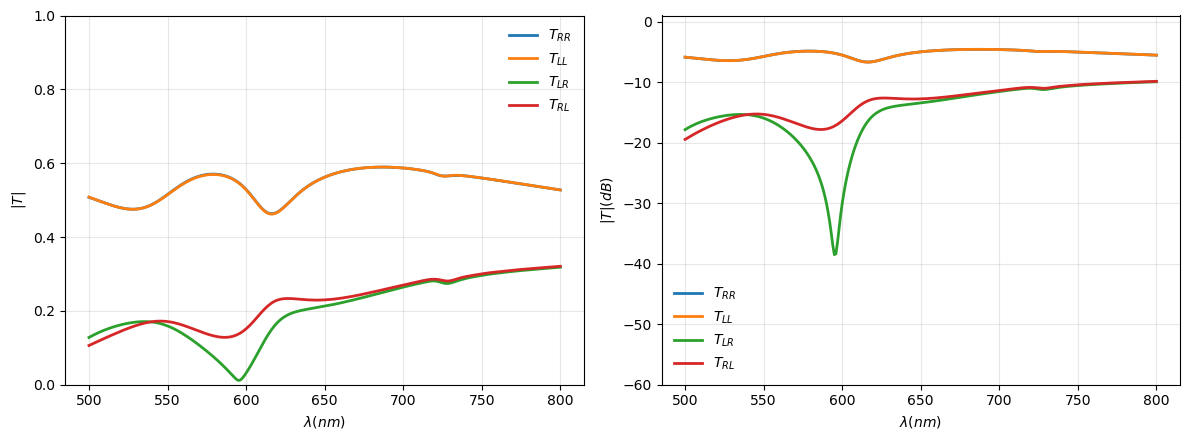

In [90]:
# plot 
print("300fs,1e-5,variant 0,mesh buffer 20 nm,dx=3nm,dy=3nm")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5,variant 0,mesh buffer 20 nm


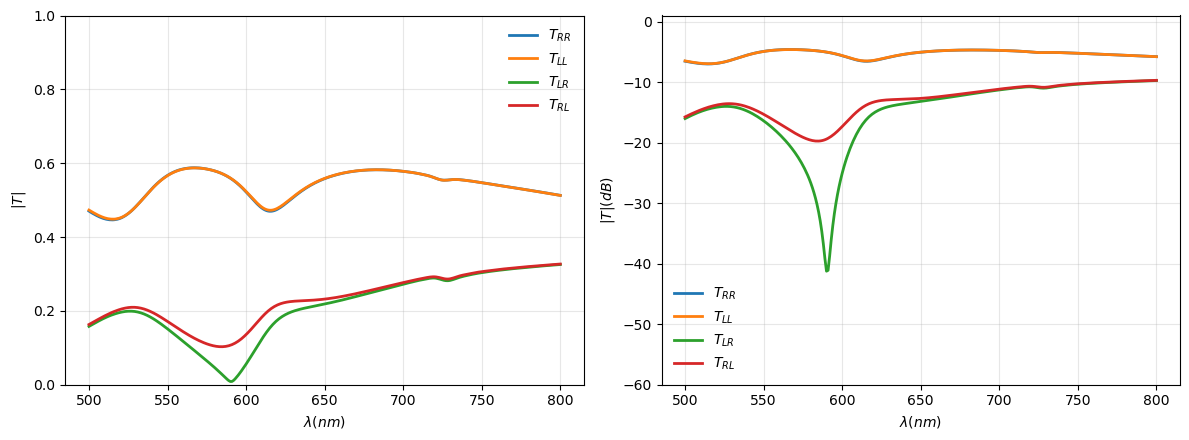

In [80]:
# plot 
print("300fs,1e-5,variant 0,mesh buffer 20 nm")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5,variant 0


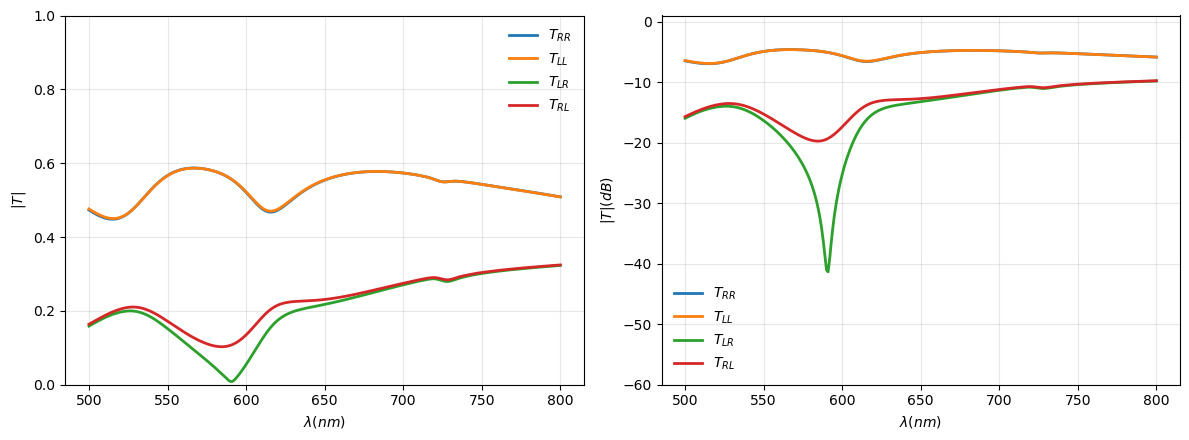

In [68]:
# plot 
print("300fs,1e-5,variant 0")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

300fs,1e-5


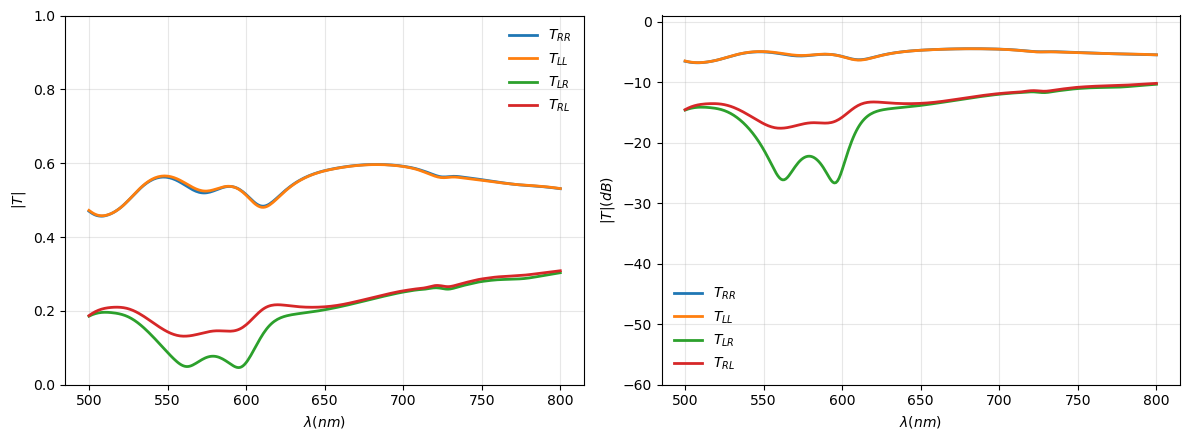

In [58]:
# plot 
print("300fs,1e-5")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

500fs,1e-5


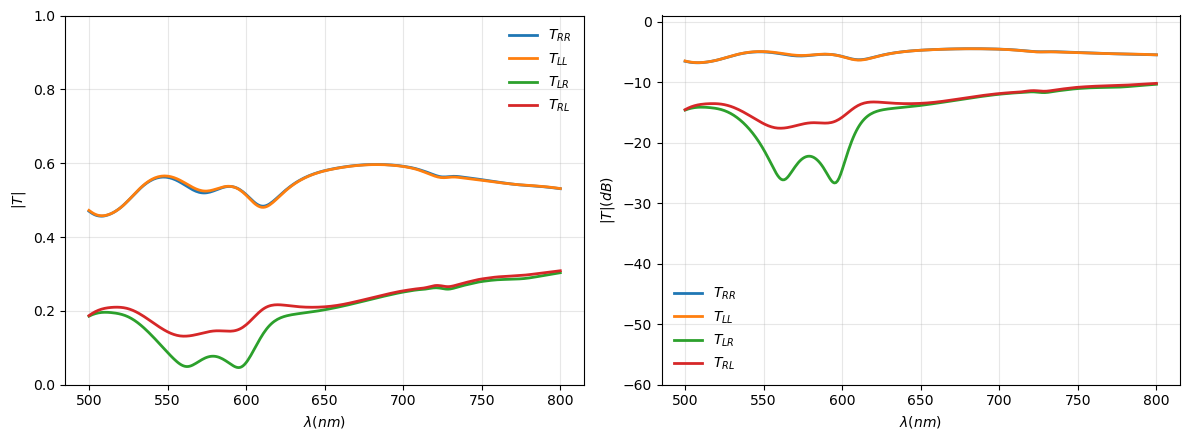

In [36]:
# plot 
print("500fs,1e-5")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

500fs,1e-6


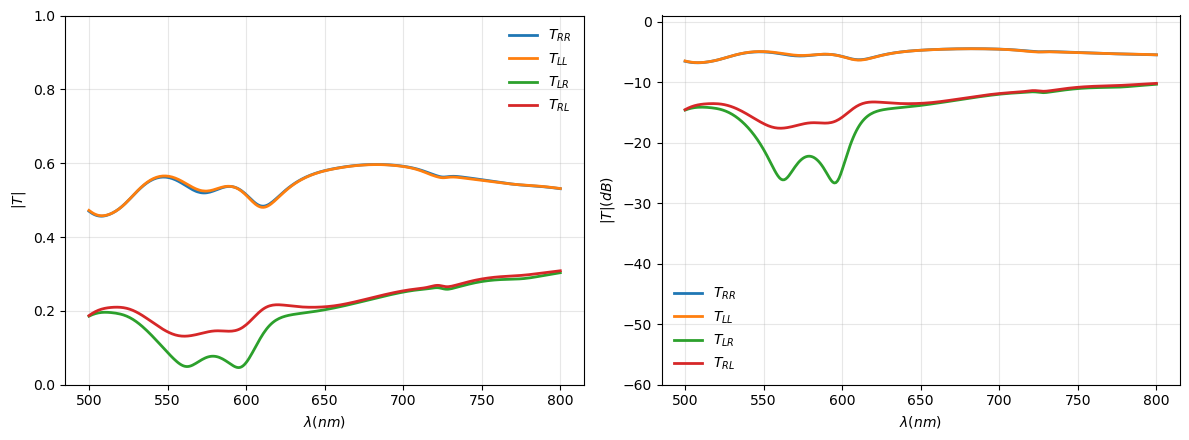

In [26]:
# plot 
print("500fs,1e-6")
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

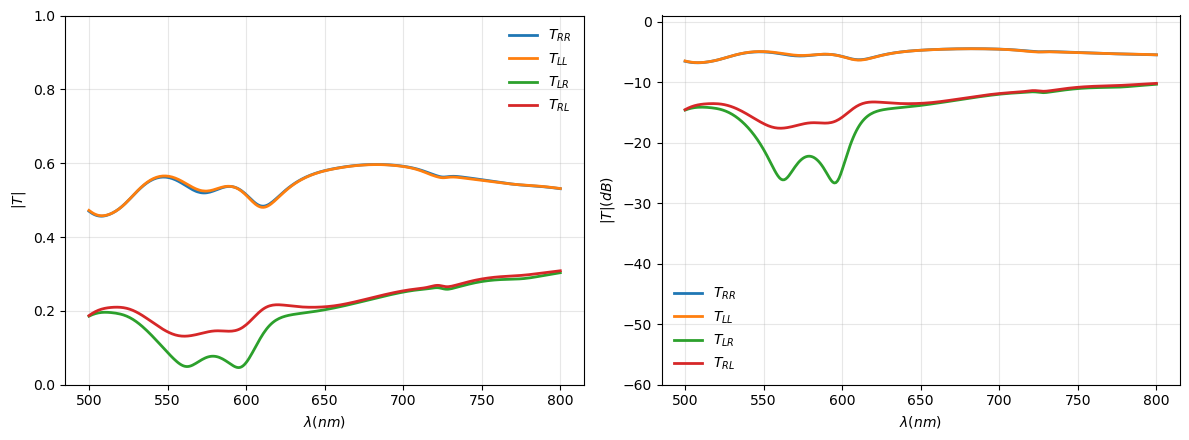

In [19]:
fig, (ax_mag, ax_db) = exy.plot_circular(df_cir, use_mathtext=True)

In [ ]:
import importlib
from pathlib import Path
import module.Z_shapedMetasurfaceSweep as Zsweep
Zsweep = importlib.reload(Zsweep)

cfg = Zsweep.ZSweepConfig(
    lam_start_nm=500.0, lam_stop_nm=800.0, npts=301,
    out_dir=Path("data/Z_sweep_master"),
    master_prefix="Z_sweep",
    save_master=True,
    sim_time_ps=1.0, auto_shutoff_level=1e-6,
    t_nm=50.0, t_z_nm=50.0, mat_z="Ag",
    mon_name="T", src_name="src", sg_name="Z"
)

l1_list = [520, 560]
l2_list = [180, 220]
l3_list = [80, 120]

# A) Direct (one FDTD session), sequential:
df_lin_all, df_cir_all = Zsweep.sweep_grid(fdtd, l1_list, l2_list, l3_list, cfg)

# B) Parallel via Job Manager:
job_dir = Path("jobs/Z_cases")               # .fsp per pol per geometry here
df_lin_all, df_cir_all = Zsweep.queue_grid_jobs(fdtd, l1_list, l2_list, l3_list, cfg, job_dir)

# Build one-row-per-geometry summary:
df_summary = Zsweep.summarize_circular(df_cir_all)
df_summary.head()
